# Title: Sample Investigation - Linux, Windows, Network, Office
### Demo version
**Notebook Version:** 1.0<br>
**Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
**Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, networkx, ipywidgets, ipython, scikit_learn, dnspython, ipwhois, folium, maxminddb_geolite2<br>
**Platforms Supported**:
- Azure Notebooks Free Compute
- Azure Notebooks DSVM
- OS Independent

**Data Sources Required**:
- Log Analytics - SecurityAlert, SecurityEvent (EventIDs 4688 and 4624/25), AuditLog_CL (Linux Auditd), OfficeActivity, AzureNetworkAnalytics_CL, Heartbeat
- (Optional) - VirusTotal (with API key)

## Description:
This is an example notebook demonstrating techniques to trace the path of an attacker in an organization. Most of the steps use relatively simple _Log Analytics_ queries but it also includes a few advanced procedures such as:
- Unpacking and decoding Linux Audit logs
- Clustering

From an initial alert (or suspect IP address) examine activity on a Linux host, a Windows and Office subscription.
Discover malicious activity related to the ip address in each of these. 

The notebook is intended to illustrate the kinds of steps and data query and analysis that you might do in a real hunt or investigation.


<a id='toc'></a>
## Table of Contents
- [Setup and Authenticate](#setup)

- [Get Alerts List](#getalertslist)
- [Choose an Alert to investigate](#enteralertid)
  - [Extract Properties and entities from alert](#extractalertproperties)
  - [Basic IP Checks](#basic_ip_checks)
    - [Check the IP Address for known C2 addresses](#check_ip_ti)
- [See What's going on on the Affected Host - Linux](#alerthost)
  - [Event Types collected](#linux_event_types)
  - [Failure Events](#linux_failure_events)
  - [Extract IPs from all Events](#linux_extract_ips)
  - [Get Logins with IP Address Recorded](#linux_login_ips)
  - [What's happening in these sessions?](#linux_login_sessions)
  - [Find Distinctive Process Patterns - Clustering](#linux_proc_cluster)
- [Alert Host Network Data](#alert_host_net)
  - [Check Communications with Other Hosts](#comms_to_other_hosts)
  - [GeoLocation Mapping](#geomap_lx_ips)
  - [Have any other hosts been communicating with this address(es)?](#other_hosts_to_ips)
- [Other Hosts Communicating with IP](#other_host_investigate)
  - [Check Host Logons](#host_logons)
  - [Examine a Logon Session](#examine_win_logon_sess)
  - [Unusual Processes on Host - Clustering](#process_clustering)
  - [Processes for Selected LogonId](#process_session)
  - [Other Events on the Host](#other_win_events)
- [Office 365 Activity](#o365)
- [Summary](#summary)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


<a id='setup'></a>[Contents](#toc)
# Setup

Make sure that you have installed packages specified in the setup (uncomment the lines to execute)

## Install Packages
The first time this cell runs for a new Azure Notebooks project or local Python environment it will take several minutes to download and install the packages. In subsequent runs it should run quickly and confirm that package dependencies are already installed. Unless you want to upgrade the packages you can feel free to skip execution of the next cell.

If you see any import failures (```ImportError```) in the notebook, please re-run this cell and answer 'y', then re-run the cell where the failure occurred.

Note you may see some warnings about package incompatibility with certain packages. This does not affect the functionality of this notebook but you may need to upgrade the packages producing the warnings to a more recent version.

In [ ]:
import sys
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)
    
# Package Installs - try to avoid if they are already installed
try:
    import msticpy.sectools as sectools
    import Kqlmagic
    from dns import reversename, resolver
    from ipwhois import IPWhois
    import folium
    
    print('If you answer "n" this cell will exit with an error in order to avoid the pip install calls,')
    print('This error can safely be ignored.')
    resp = input('msticpy and Kqlmagic packages are already loaded. Do you want to re-install? (y/n)')
    if resp.strip().lower() != 'y':
        sys.exit('pip install aborted - you may skip this error and continue.')
except ImportError:
    pass

print('\nPlease wait. Installing required packages. This may take a few minutes...')
!pip install git+https://github.com/microsoft/msticpy --upgrade --user
!pip install Kqlmagic --no-cache-dir --upgrade --user

# Additional packages used in this notebook.
!pip install dnspython --upgrade 
!pip install ipwhois --upgrade 
!pip install folium --upgrade  

# Uncomment to refresh the maxminddb database
# !pip install maxminddb-geolite2 --upgrade 
print('To ensure that the latest versions of the installed libraries '
      'are used, please restart the current kernel and run '
      'the notebook again skipping this cell.')

If you answer "n" this cell will exit with an error in order to avoid the pip install calls,
This error can safely be ignored.


In [1]:
# Imports
import sys
import warnings

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interactive

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

import msticpy.sectools as sectools
import msticpy.nbtools as mas
import msticpy.nbtools.kql as qry
import msticpy.nbtools.nbdisplay as nbdisp
from msticpy.sectools.geoip import GeoLiteLookup

import platform
from datetime import datetime, timedelta
from dns import reversename, resolver
from ipwhois import IPWhois

# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

WIDGET_DEFAULTS = {'layout': widgets.Layout(width='95%'),
                   'style': {'description_width': 'initial'}}
display(HTML(mas.util._TOGGLE_CODE_PREPARE_STR))

### Copy Last Query to Clipboard
This section adds an IPython magic command 'la'. The magic is used as follows:

```%la [pythonvar|string]```

If used with no arguments it will copy the last KQL query to clipboard and display a link to take you to the Sentinel/Log Analytics portal. If the argument is a variable the value of the variable is copied, otherwise the string is copied.

When using the **%%la** cell magic form the entire cell is copied to the clipboard.

The URL uses the current config settings for workspace and subscription.


In [9]:
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)
from collections import OrderedDict

def copy_to_clipboard(copy_text):
    pd.DataFrame([copy_text]).to_clipboard(index=False,header=False)


LA_URL=('https://ms.portal.azure.com/'
        '?feature.showassettypes=Microsoft_Azure_Security_Insights_SecurityInsightsDashboard'
        '#blade/Microsoft_Azure_Security_Insights/MainMenuBlade/7'
        '/subscriptionId/{sub_id}'
        '/resourceGroup/{res_group}'
        '/workspaceName/{ws_name}')

LA_URL_BARE=('https://ms.portal.azure.com/'
             '?feature.showassettypes=Microsoft_Azure_Security_Insights_SecurityInsightsDashboard'
             '#blade/Microsoft_Azure_Security_Insights/MainMenuBlade/')
@register_line_cell_magic
def la(line, cell=None):
    KQL_MAGIC_RESULT = '_kql_raw_result_'
    
    
    #import pdb; pdb.set_trace()
    if not cell and not line or line.strip() == KQL_MAGIC_RESULT:
        if KQL_MAGIC_RESULT in globals():
            copy_to_clipboard(globals()[KQL_MAGIC_RESULT].query)
            print('Last kql query copied to clipboard.')
    elif line and cell is None:
        if line in globals():
            copy_to_clipboard(globals()[line])
            print(f'Value of {line} copied to clipboard.')
        elif line in locals():
            copy_to_clipboard(locals()[line])
            print(f'Value of {line} copied to clipboard.')
        else:
            copy_to_clipboard(line)
            print(f'Copied to clipboard.')
    else:
        copy_to_clipboard(cell)
        print(f'Copied to clipboard.')
    
    try:
        ws_config = WorkspaceConfig(ws_config_file)
        url = LA_URL.format(sub_id=ws_config['subscription_id'],
                        res_group=ws_config['resource_group'], 
                        ws_name=ws_config['workspace_name'])
    except:
        url = LA_URL_BARE
    return HTML(f'<a target="_new" href="{url}">Open Log Analytics</a>')
del la

# Create an observation collector list
from collections import namedtuple
Observation = namedtuple('Observation', ['caption', 'description', 'item', 'link'])
observation_list = OrderedDict()
def display_observation(observation):
    display(Markdown(f'### {observation.caption}'))
    display(Markdown(observation.description))
    display(Markdown(f'[Go to details](#{observation.link})'))
    display(observation.item)

def add_observation(observation):
    observation_list[observation.caption] = observation


### Get WorkspaceId
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.

In [11]:
import os
from msticpy.nbtools.wsconfig import WorkspaceConfig
ws_config_file = 'config.json'

WORKSPACE_ID = None
TENANT_ID = None
try:
    ws_config = WorkspaceConfig(ws_config_file)
    display(Markdown(f'Read Workspace configuration from local config.json for workspace **{ws_config["workspace_name"]}**'))
    for cf_item in ['tenant_id', 'subscription_id', 'resource_group', 'workspace_id', 'workspace_name']:
        display(Markdown(f'**{cf_item.upper()}**: {ws_config[cf_item]}'))
                     
    if ('cookiecutter' not in ws_config['workspace_id'] or
            'cookiecutter' not in ws_config['tenant_id']):
        WORKSPACE_ID = ws_config['workspace_id']
        TENANT_ID = ws_config['tenant_id']
except:
    pass

if not WORKSPACE_ID or not TENANT_ID:
    display(Markdown('**Workspace configuration not found.**\n\n'
                     'Please go to your Log Analytics workspace, copy the workspace ID'
                     ' and/or tenant Id and paste here.<br> '
                     'Or read the workspace_id from the config.json in your Azure Notebooks project.'))
    ws_config = None
    ws_id = mas.GetEnvironmentKey(env_var='WORKSPACE_ID',
                              prompt='Please enter your Log Analytics Workspace Id:', auto_display=True)
    ten_id = mas.GetEnvironmentKey(env_var='TENANT_ID',
                              prompt='Please enter your Log Analytics Tenant Id:', auto_display=True) 

Read Workspace configuration from local config.json for workspace **ASIHuntOMSWorkspaceV4**

**TENANT_ID**: 72f988bf-86f1-41af-91ab-2d7cd011db47

**SUBSCRIPTION_ID**: 40dcc8bf-0478-4f3b-b275-ed0a94f2c013

**RESOURCE_GROUP**: ASIHuntOMSWorkspaceRG

**WORKSPACE_ID**: 52b1ab41-869e-4138-9e40-2a4457f09bf0

**WORKSPACE_NAME**: ASIHuntOMSWorkspaceV4

### Authenticate to Log Analytics
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.

In [12]:
if not WORKSPACE_ID or not TENANT_ID:
    try:
        WORKSPACE_ID = ws_id.value
        TENANT_ID = ten_id.value
    except NameError:
        raise ValueError('No workspace or Tenant Id.')

mas.kql.load_kql_magic()
%kql loganalytics://code().tenant(TENANT_ID).workspace(WORKSPACE_ID)

In [13]:
%kql search * | summarize RowCount=count() by Type | project-rename Table=Type
la_table_set = _kql_raw_result_.to_dataframe()
table_index = la_table_set.set_index('Table')['RowCount'].to_dict()
display(Markdown('Current data in workspace'))
display(la_table_set.T)

<IPython.core.display.Javascript object>

Current data in workspace

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
Table,ConfigurationData,SecurityBaselineSummary,Syslog,SecurityDetection,Operation,ProtectionStatus,ConfigurationChange,AzureMetrics,HuntingBookmark,AzureActivity,OfficeActivity,Update,Heartbeat,ProcessCreationSqlV2_CL,SecurityBaseline,SSHAlertDataV1_CL,AwsEventsSample_CL,Usage,Syslog_CL,SqlLogArtifacts_CL,UpdateSummary,ThreatIntelSample_CL,AzureDiagnostics,SecurityEvent,SecurityAlert,AzureNetworkAnalytics_CL,SSHAlertDataV2_CL,ProcessCreationSqlV1_CL,ScratchData_CL,BYOThreatIntelv1_CL,AuditLog_CL,SSHAlertDataV2cls_CL,MruArtifacts_CL,AutorunsArtifacts_CL,AmcacheArtifacts_CL
RowCount,241901,343,1333317,6514,7164,9613,21345,7553368,18,116630,1994,218050,692921,75323,52484,1,510,37697,3451,141584,1071,27,174370,1399465,6726,9954831,15,75323,70792,6,53356839,1,6714992,76846402,362040170


<a id='enteralertid'></a>[Contents](#toc)
# Choose Alert to Investigate
Pick an alert from a list of retrieved alerts.

This section extracts the alert information and entities into a SecurityAlert object allowing us to query the properties more reliably. 

In particular, we use the alert to automatically provide parameters for queries and UI elements.
Subsequent queries will use properties like the host name and derived properties such as the OS family (Linux or Windows) to adapt the query. Query time selectors like the one above will also default to an origin time that matches the alert selected.

The alert view below shows all of the main properties of the alert plus the extended property dictionary (if any) and JSON representations of the Entity.

### Choose Timespan to look for alerts

Specify a time range to search for alerts. One this is set run the following cell to retrieve any alerts in that time window.<br>
You can change the time range and re-run the queries until you find the alerts that you want.

In [14]:
alert_q_times = mas.QueryTime(units='day', max_before=20, before=2, max_after=1)
alert_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

### Select alert from list
As you select an alert, the main properties will be shown below the list.<br>
Use the filter box to narrow down your search to any substring in the AlertName.

In [16]:
# Query for alerts
alert_counts = qry.list_alerts_counts(provs=[alert_q_times])
alert_list = qry.list_alerts(provs=[alert_q_times])
print(len(alert_counts), ' distinct alert types')
print(len(alert_list), ' distinct alerts')

from msticpy.nbtools.entityschema import GeoLocation
from msticpy.sectools.geoip import GeoLiteLookup
iplocation = GeoLiteLookup()

security_alert = None
alert_ip_entities = []

def show_full_alert(selected_alert):
    global security_alert, alert_ip_entities
    security_alert = mas.SecurityAlert(alert_select.selected_alert)
    alert_ip_entities = get_alert_ips(security_alert)
    mas.disp.display_alert(security_alert, show_entities=True)
    
def get_alert_ips(alert):
    alert_ip_entities = [e for e in alert.entities if isinstance(e, mas.IpAddress)]

    # Extract any additional IP addresses from text in the alert
    ioc_extractor = sectools.IoCExtract()
    alert_iocs = ioc_extractor.extract(src=str(alert))
    addl_ip_addrs = alert_iocs.get('ipv4', [])
    
    if addl_ip_addrs:
        _, ip_entities = iplocation.lookup_ip(ip_addr_list=addl_ip_addrs)

        current_ips = [e.Address for e in alert_ip_entities]
        for new_ip_entity in ip_entities:
            if new_ip_entity.Address not in current_ips:
                alert_ip_entities.append(new_ip_entity)
    return alert_ip_entities
            
# Display the alert list
alert_select = mas.AlertSelector(alerts=alert_list, action=show_full_alert)
alert_select.display()

8  distinct alert types
29  distinct alerts


# See what is happening on the host in this Alert


In [28]:
print(security_alert.primary_host)
print(security_alert.TimeGenerated)

{ 'HostName': 'MSTICALERTSLXVM2',
  'NetBiosName': 'MSTICALERTSLXVM2',
  'OSFamily': 'Linux',
  'Type': 'host'}
2019-02-16 03:24:04


### Observations
- We can see that it's a Linux host and can view the alert time.
- Set the time boundaries to be a hour or two either side of the alert

In [27]:
%config Kqlmagic.auto_dataframe=False
host1_q_times = mas.QueryTime(label='Set time bounds for alert host - at least 1hr either side of the alert',
                           units='hour', max_before=48, before=2, after=1, 
                           max_after=24, origin_time=security_alert.StartTimeUtc)
host1_q_times.display()

HTML(value='<h4>Set time bounds for alert host - at least 1hr either side of the alert</h4>')

#### Data is in Raw Auditd format so we need to unpack and re-assemble it

In [31]:
import pickle
from os import path

# Retrieve Linux auditd events
linux_events = r'''
AuditLog_CL
| where Computer has '{hostname}'
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| extend mssg_parts = extract_all(@"type=(?P<type>[^\s]+)\s+msg=audit\((?P<mssg_id>[^)]+)\):\s+(?P<mssg>[^\r]+)\r?", dynamic(['type', 'mssg_id', 'mssg']), RawData)
| extend mssg_type = tostring(mssg_parts[0][0]), mssg_id = tostring(mssg_parts[0][1])
| project TenantId, TimeGenerated, Computer, mssg_type, mssg_id, mssg_parts
| extend mssg_content = split(mssg_parts[0][2],' ')
| extend typed_mssg = pack(mssg_type, mssg_content)
| summarize AuditdMessage = makelist(typed_mssg) by TenantId, TimeGenerated, Computer, mssg_id
'''.format(start=host1_q_times.start, end=host1_q_times.end,
           hostname=security_alert.hostname)

_PICKLE_FILE = 'lx_auditd.cache'
linux_events_all = None
if path.exists(_PICKLE_FILE):
    with open(_PICKLE_FILE, 'rb') as cache_file:
        linux_events_all = pickle.load(cache_file)

if linux_events_all is None:
    print('getting data...')
    %kql -query linux_events
    linux_events_df = _kql_raw_result_.to_dataframe()
    print(f'{len(linux_events_df)} raw auditd mssgs downloaded')


import codecs
from datetime import datetime
encoded_params = {'EXECVE': {'a0', 'a1', 'a2', 'a3', 'arch'},
                  'PROCTITLE': {'proctitle'},
                  'USER_CMD': {'cmd'}}

def unpack_auditd(audit_str):
    event_dict = {}
    for record in audit_str:
        
        for rec_key, rec_val in record.items():
            rec_dict = {}
            encoded_fields_map = encoded_params.get(rec_key, None)
            for rec_item in rec_val:
                rec_split = rec_item.split('=', maxsplit=1)
                if len(rec_split) == 1:
                    rec_dict[rec_split[0]] = None
                    continue
                if (not encoded_fields_map or rec_split[1].startswith('"') or
                        rec_split[0] not in encoded_fields_map):
                    field_value = rec_split[1].strip('\"')
                else:
                    try:
                        field_value = codecs.decode(rec_split[1], 'hex').decode('utf-8')
                    except:
                        field_value = rec_split[1]
                        print(rec_val)
                        print('ERR:', rec_key, rec_split[0], rec_split[1], type(rec_split[1]))
                rec_dict[rec_split[0]] = field_value
            event_dict[rec_key] = rec_dict
        
    return event_dict

USER_START = {'pid': 'int', 'uid': 'int', 'auid': 'int', 
              'ses': 'int', 'msg': None, 'acct': None, 'exe': None, 
              'hostname': None, 'addr': None, 'terminal': None, 
              'res': None}
FIELD_DEFS = {'SYSCALL': {'success': None, 'ppid': 'int', 'pid': 'int', 
                          'auid': 'int', 'uid': 'int', 'gid': 'int',
                          'euid': 'int', 'egid': 'int', 'ses': 'int',
                          'exe': None, 'com': None},
              'CWD': {'cwd': None},
              'PROCTITLE': {'proctitle': None},
              'LOGIN': {'pid': 'int', 'uid': 'int', 'tty': None, 'old-ses': 'int', 
                        'ses': 'int', 'res': None},
              'EXECVE': {'argc': 'int', 'a0': None, 'a1': None, 'a2': None},
              'USER_START': USER_START,
              'USER_END': USER_START,
              'CRED_DISP': USER_START,
              'USER_ACCT': USER_START,
              'CRED_ACQ': USER_START,
              'USER_CMD': {'pid': 'int', 'uid': 'int', 'auid': 'int', 
                           'ses': 'int', 'msg': None, 'cmd': None,
                           'terminal': None, 'res': None},
             }

def extract_event(message_dict):
    if 'SYSCALL' in message_dict:
        proc_create_dict = {}
        for mssg_type in ['SYSCALL', 'CWD', 'EXECVE', 'PROCTITLE']:
            if (not mssg_type in message_dict or
                    not mssg_type in FIELD_DEFS) :
                continue
            for fieldname, conv in FIELD_DEFS[mssg_type].items():
                value = message_dict[mssg_type].get(fieldname, None)
                if not value:
                    continue
                if conv:
                    if conv == 'int':
                        value = int(value)
                        if value == 4294967295:
                            value = -1
                proc_create_dict[fieldname] = value
            if mssg_type == 'EXECVE':
                args = int(proc_create_dict.get('argc', 1))
                arg_strs = []
                for arg_idx in range(0, args):
                    arg_strs.append(proc_create_dict.get(f'a{arg_idx}', ''))
                    
                proc_create_dict['cmdline'] = ' '.join(arg_strs)
        return 'SYSCALL', proc_create_dict
    else:
        event_dict = {}                                            
        for mssg_type, mssg in message_dict.items():
            if mssg_type in FIELD_DEFS:
                for fieldname, conv in FIELD_DEFS[mssg_type].items():
                    value = message_dict[mssg_type].get(fieldname, None)
                    if conv:
                        if conv == 'int':
                            value = int(value)
                            if value == 4294967295:
                                value = -1
                    event_dict[fieldname] = value
            else:
                
                event_dict.update(message_dict[mssg_type])
        return list(message_dict.keys())[0], event_dict

    
def move_cols_to_front(df, column_count):
    """Reorder columms to put the last column count cols to front."""
    return df[list(df.columns[-column_count:]) + list(df.columns[:-column_count])]


def extract_events_to_df(data, event_type=None, verbose=False):
    
    if verbose:
        start_time = datetime.utcnow()
        print(f'Unpacking auditd messages for {len(data)} events...')
    tmp_df = (data.apply(lambda x: extract_event(unpack_auditd(x.AuditdMessage)), 
                         axis=1, result_type='expand')
                  .rename(columns={0: 'EventType', 
                                   1: 'EventData'})
                  )
    # if only one type of event is requested
    if event_type:
        tmp_df = tmp_df[tmp_df['EventType'] == event_type]
        if verbose:
            print(f'Event subset = ', event_type, ' (events: {len(tmp_df)})')
    
    if verbose:
        print('Building output dataframe...')
        
    tmp_df = (tmp_df.apply(lambda x: pd.Series(x.EventData), axis=1)
              .merge(tmp_df[['EventType']], left_index=True, right_index=True)
              .merge(data.drop(['AuditdMessage'], axis=1), 
                 how='inner', left_index=True, right_index=True)
              .dropna(axis=1, how='all'))
    
    if verbose:
        print('Fixing timestamps...')
        
    # extract real timestamp from mssg_id
    tmp_df['TimeStamp'] = (tmp_df.apply(lambda x:
                                        datetime.utcfromtimestamp(float(x.mssg_id.split(':')[0])),
                                        axis=1))
    tmp_df = (tmp_df.drop(['TimeGenerated'], axis=1)
                    .rename(columns={'TimeStamp': 'TimeGenerated'})
                    .pipe(move_cols_to_front, column_count=5))
    if verbose:
        print(f'Complete. {len(tmp_df)} output rows', end=' ')
        delta = datetime.utcnow() - start_time
        print(f'time: {delta.seconds + delta.microseconds/1_000_000} sec')
        
    return tmp_df


def get_event_subset(data, event_type):
    return (data[data['EventType'] == event_type]
             .dropna(axis=1, how='all')
             .infer_objects())


if linux_events_all is None:
    linux_events_all = extract_events_to_df(linux_events_df, verbose=True)

    with open(_PICKLE_FILE, 'ab') as cache_file:
        print('Writing cache file')
        pickle.dump(linux_events_all, cache_file)
        
print(f'{len(linux_events_all)} events read.')

getting data...
17469 raw auditd mssgs downloaded
Unpacking auditd messages for 17469 events...
Building output dataframe...
Fixing timestamps...
Complete. 17469 output rows time: 12.448911 sec
Writing cache file
17469 events read.


<a id='linux_login_ips'></a>[Contents](#toc)
## Get Any External Logins (that have an IP Address Recorded)

In [32]:
lx_proc_create = get_event_subset(linux_events_all,'SYSCALL')
print(f'{len(lx_proc_create)} Process Create Events')

lx_login = (get_event_subset(linux_events_all, 'LOGIN')
        .merge(get_event_subset(linux_events_all, 'CRED_ACQ'), 
               how='inner',
               left_on=['old-ses', 'pid', 'uid'], 
               right_on=['ses', 'pid', 'uid'],
               suffixes=('', '_cred')).drop(['old-ses','TenantId_cred', 
                                             'Computer_cred'], axis=1)
        .dropna(axis=1, how='all'))
print(f'{len(lx_login)} Login Events')


                   

logins_with_ips = (lx_login[lx_login['addr'] != '?']
                   [['Computer', 'TimeGenerated','pid', 'ses', 
                     'acct', 'addr', 'exe', 'hostname', 'msg',
                     'res_cred', 'ses_cred', 'terminal']])
if len(logins_with_ips) > 0:
    display(logins_with_ips)
    
    # add the source IPs if not alert 
    new_ips = logins_with_ips['addr'].drop_duplicates().tolist()
    current_ips = [e.Address for e in alert_ip_entities]
    for new_ip in new_ips:
        if new_ip not in current_ips:
            ip_entity = mas.IpAddress(Address=new_ip)
            iplocation.lookup_ip(ip_entity=ip_entity)
            alert_ip_entities.append(ip_entity)
    

display(Markdown('### What is happening in these sessions?'))

# Mapping to Windows-like event to work more easily with clustering
lx_to_proc_create = {'acct': 'SubjectUserName',
                     'uid': 'SubjectUserSid',
                     'user': 'SubjectUserName',
                     'ses': 'SubjectLogonId',
                     'pid': 'NewProcessId',
                     'exe': 'NewProcessName',
                     'ppid': 'ProcessId',
                     'cmdline': 'CommandLine',}

proc_create_to_lx = {'SubjectUserName': 'acct',
                     'SubjectUserSid': 'uid',
                     'SubjectUserName': 'user',
                     'SubjectLogonId': 'ses',
                     'NewProcessId': 'pid',
                     'NewProcessName': 'exe',
                     'ProcessId': 'ppid',
                     'CommandLine': 'cmdline',}

lx_to_logon = {'acct': 'SubjectUserName',
               'auid': 'SubjectUserSid',
               'user': 'TargetUserName',
               'uid': 'TargetUserSid',
               'ses': 'TargetLogonId',
               'exe': 'LogonProcessName',
               'terminal': 'LogonType',
               'msg': 'AuthenticationPackageName',
               'res': 'Status',
               'addr': 'IpAddress',
               'hostname': 'WorkstationName',}

logon_to_lx = {'SubjectUserName': 'acct',
               'SubjectUserSid': 'auid',
               'TargetUserName': 'user',
               'TargetUserSid': 'uid',
               'TargetLogonId': 'ses',
               'LogonProcessName': 'exe',
               'LogonType': 'terminal',
               'AuthenticationPackageName': 'msg',
               'Status': 'res',
               'IpAddress': 'addr',
               'WorkstationName': 'hostname',}

lx_proc_create_trans = lx_proc_create.rename(columns=lx_to_proc_create)
lx_login_trans = lx_login.rename(columns=lx_to_logon)

print('analyzing data...')
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features

feature_procs_h1 = add_process_features(input_frame=lx_proc_create_trans,
                                        path_separator=security_alert.path_separator)


# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs_h1,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore',
                                                                    'SubjectUserSid'],
                                                    time_column='TimeGenerated',
                                                    max_cluster_distance=0.0001)
print('Number of input events:', len(feature_procs_h1))
print('Number of clustered events:', len(clus_events))
(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                           'NewProcessName', 'CommandLine', 
                                           'ClusterSize', 'commandlineTokensFull',
                                           'SubjectLogonId', 'SubjectUserSid',
                                           'pathScore', 'isSystemSession']]
    .sort_values('ClusterSize', ascending=True));

                   

def view(x=''):
    procs = (clus_events[clus_events['SubjectLogonId']==x]
            [['TimeGenerated', 'NewProcessName','CommandLine', 
              'NewProcessId', 'SubjectUserSid', 'cwd', 'ClusterSize', 'SubjectLogonId']])
    display(Markdown(f'{len(procs)} process events'))
    display(procs.query('SubjectUserSid != 0'))
    
items = logins_with_ips['ses'].unique().tolist()
w = widgets.Select(options=items, description='Select Session to view', **WIDGET_DEFAULTS)
interactive(view, x=w)

13976 Process Create Events
265 Login Events


,Computer,TimeGenerated,pid,ses,acct,addr,exe,hostname,msg,res_cred,ses_cred,terminal
63,MSTICAlertsLxVM2,2019-02-16 03:51:55.865,22838,190715,dbadmin,23.97.60.214,/usr/sbin/sshd,23.97.60.214,'op=PAM:setcred,success',-1,ssh
169,MSTICAlertsLxVM2,2019-02-16 03:23:17.590,19803,190671,dbadmin,23.97.60.214,/usr/sbin/sshd,23.97.60.214,'op=PAM:setcred,success',-1,ssh


### What is happening in these sessions?

analyzing data...
Number of input events: 13976
Number of clustered events: 155


interactive(children=(Select(description='Select Session to view', layout=Layout(width='95%'), options=(190715…

### Observations
- We can see that the attacker is retrieve host information including contents of /etc/passwd.
- Looks like a shell script is being downloaded and set as executable. 
- Finally, looks like something is happening with the cron scheduler - this is just listing crontab but likely this is a precursor to installing a persistent presence on the machine.

<a id='alert_host_net'></a>[Contents](#toc)
# Host Network Data

Looking for IP addresses of  MSTICALERTSLXVM2
getting data...
10.0.3.4
104.211.30.1


### Flow Time and Protocol Distribution

getting data... done


Loading BokehJS ...

Alert start time =  2019-02-16 03:23:54


### GeoLocation Mapping for external IPs

<p style="color:red">Warning: the folium mapping library does not display correctly in some browsers.</p><br>If you see a blank image please retry with a different browser.

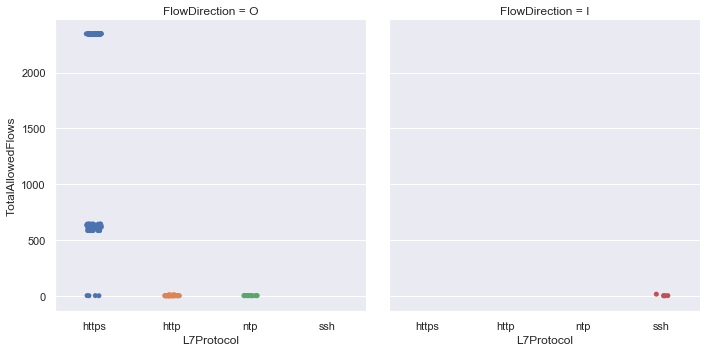

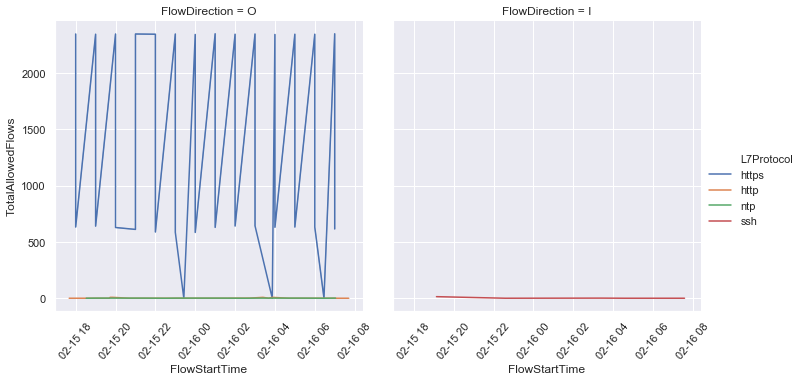

In [33]:
from datetime import timedelta
import folium
from folium.plugins import MarkerCluster
from numbers import Number
import warnings

host_entities = [e for e in security_alert.entities if isinstance(e, mas.Host)]
if len(host_entities) == 1:
    alert_host_entity = host_entities[0]
    host_name = alert_host_entity.HostName
    resource = alert_host_entity.AzureID
else:
    host_name = None
    alert_host_entity = None
    print('Error: Could not determine host entity from alert.')


def create_ip_map():
    folium_map = folium.Map(zoom_start=7, tiles=None, width='100%', height='100%')
    folium_map.add_tile_layer(name='IPEvents')
    return folium_map

def add_ip_cluster(folium_map, ip_entities, alert=None, **icon_props):
    if not folium_map:
        folium_map = create_ip_map()
    
    for ip_entity in ip_entities:
        if not (isinstance(ip_entity.Location.Latitude, Number) and
                isinstance(ip_entity.Location.Longitude, Number)):
            warnings.warn("Invalid location information for IP: " + ip_entity.Address,
                          RuntimeWarning)
            continue
        loc_props = ', '.join([f'{key}={val}' for key, val in 
                               ip_entity.Location.properties.items() if val])
        popup_text = "{loc_props}<br>{IP}".format(IP=ip_entity.Address,
                                                  loc_props=loc_props)
        tooltip_text = '{City}, {CountryName}'.format(**ip_entity.Location.properties)
        if alert:
            popup_text = f'{popup_text}<br>{alert.AlertName}'
        if ip_entity.AdditionalData:
            addl_props = ', '.join([f'{key}={val}' for key, val in 
                                    ip_entity.AdditionalData.items() if val])
            popup_text = f'{popup_text}<br>{addl_props}'
            tooltip_text = f'{tooltip_text}, {addl_props}'
        marker = folium.Marker(
            location = [ip_entity.Location.Latitude, ip_entity.Location.Longitude],
            popup=popup_text,
            tooltip=tooltip_text,
            icon=folium.Icon(**icon_props)
        )
        marker.add_to(folium_map)

    return folium_map

print('Looking for IP addresses of ', host_name)
aznet_query = '''
AzureNetworkAnalytics_CL 
| where VirtualMachine_s has \'{host}\'
| where ResourceType == 'NetworkInterface'
| top 1 by TimeGenerated desc
| project PrivateIPAddresses = PrivateIPAddresses_s, 
    PublicIPAddresses = PublicIPAddresses_s
'''.format(host=host_name)
%kql -query aznet_query
az_net_df = _kql_raw_result_.to_dataframe()


oms_heartbeat_query = '''
Heartbeat
| where Computer has \'{host}\'
| top 1 by TimeGenerated desc nulls last
| project ComputerIP, OSType, OSMajorVersion, OSMinorVersion, ResourceId, RemoteIPCountry, 
RemoteIPLatitude, RemoteIPLongitude, SourceComputerId
'''.format(host=host_name)
%kql -query oms_heartbeat_query
oms_heartbeat_df = _kql_raw_result_.to_dataframe()
#display(oms_heartbeat_df[['ComputerIP']])
#display(az_net_df)

print('getting data...')
# Get the host entity and add this IP and system info to the 
try:
    if not inv_host_entity:
        inv_host_entity = mas.Host()
        inv_host_entity.HostName = host_name
except NameError:
    inv_host_entity = mas.Host()
    inv_host_entity.HostName = host_name

def convert_to_ip_entities(ip_str):
    ip_entities = []
    if ip_str:
        if ',' in ip_str:
            addrs = ip_str.split(',')
        elif ' ' in ip_str:
            addrs = ip_str.split(' ')
        else:
            addrs = [ip_str]
        for addr in addrs:
            ip_entity = mas.IpAddress()
            ip_entity.Address = addr.strip()
            iplocation.lookup_ip(ip_entity=ip_entity)
            ip_entities.append(ip_entity)
            print(addr)
    return ip_entities

# Add this information to our inv_host_entity
if len(az_net_df) == 1:
    priv_addr_str = az_net_df['PrivateIPAddresses'].loc[0]
    inv_host_entity.properties['private_ips'] = convert_to_ip_entities(priv_addr_str)

    pub_addr_str = az_net_df['PublicIPAddresses'].loc[0]
    inv_host_entity.properties['public_ips'] = convert_to_ip_entities(pub_addr_str)

retrieved_address = [ip.Address for ip in inv_host_entity.properties['public_ips']]
if len(oms_heartbeat_df) == 1:
    if oms_heartbeat_df['ComputerIP'].loc[0]:
        oms_address = oms_heartbeat_df['ComputerIP'].loc[0]
        if oms_address not in retrieved_address:
            ip_entity = mas.IpAddress()
            ip_entity.Address = oms_address
            iplocation.lookup_ip(ip_entity=ip_entity)
            inv_host_entity.properties['public_ips'].append(ip_entity)
        
    inv_host_entity.OSFamily = oms_heartbeat_df['OSType'].loc[0]
    inv_host_entity.AdditionalData['OSMajorVersion'] = oms_heartbeat_df['OSMajorVersion'].loc[0]
    inv_host_entity.AdditionalData['OSMinorVersion'] = oms_heartbeat_df['OSMinorVersion'].loc[0]
    inv_host_entity.AdditionalData['SourceComputerId'] = oms_heartbeat_df['SourceComputerId'].loc[0]

# print('Updated Host Entity\n')
# print(inv_host_entity)

display(Markdown('### Flow Time and Protocol Distribution'))
# Azure Network Analytics Base Query
az_net_analytics_query =r'''
AzureNetworkAnalytics_CL 
| where SubType_s == 'FlowLog'
| where FlowStartTime_t >= datetime({start})
| where FlowEndTime_t <= datetime({end})
| project TenantId, TimeGenerated, 
    FlowStartTime = FlowStartTime_t, 
    FlowEndTime = FlowEndTime_t, 
    FlowIntervalEndTime = FlowIntervalEndTime_t, 
    FlowType = FlowType_s,
    ResourceGroup = split(VM_s, '/')[0],
    VMName = split(VM_s, '/')[1],
    VMIPAddress = VMIP_s, 
    PublicIPs = extractall(@"([\d\.]+)[|\d]+", dynamic([1]), PublicIPs_s),
    SrcIP = SrcIP_s,
    DestIP = DestIP_s,
    ExtIP = iif(FlowDirection_s == 'I', SrcIP_s, DestIP_s),
    L4Protocol = L4Protocol_s, 
    L7Protocol = L7Protocol_s, 
    DestPort = DestPort_d, 
    FlowDirection = FlowDirection_s,
    AllowedOutFlows = AllowedOutFlows_d, 
    AllowedInFlows = AllowedInFlows_d,
    DeniedInFlows = DeniedInFlows_d, 
    DeniedOutFlows = DeniedOutFlows_d,
    RemoteRegion = AzureRegion_s,
    VMRegion = Region_s
| extend AllExtIPs = iif(isempty(PublicIPs), pack_array(ExtIP), 
                         iif(isempty(ExtIP), PublicIPs, array_concat(PublicIPs, pack_array(ExtIP)))
                         )
| project-away ExtIP
| mvexpand AllExtIPs
{where_clause}
'''

start = security_alert.StartTimeUtc - timedelta(seconds=(10 * 60 * 60))
end = security_alert.StartTimeUtc + timedelta(seconds=(5 * 60 * 60))


### Flow Time and Protocol Distribution

all_alert_host_ips = inv_host_entity.private_ips + inv_host_entity.public_ips
host_ips = {'\'{}\''.format(i.Address) for i in all_alert_host_ips}
alert_host_ip_list = ','.join(host_ips)

az_ip_where = f'''
| where (VMIPAddress in ({alert_host_ip_list}) 
        or SrcIP in ({alert_host_ip_list}) 
        or DestIP in ({alert_host_ip_list}) 
        ) and 
    (AllowedOutFlows > 0 or AllowedInFlows > 0)'''
print('getting data...', end=' ')
az_net_query_byip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                  start=start,
                                                  end=end)

net_default_cols = ['FlowStartTime', 'FlowEndTime', 'VMName', 'VMIPAddress', 
                'PublicIPs', 'SrcIP', 'DestIP', 'L4Protocol', 'L7Protocol',
                'DestPort', 'FlowDirection', 'AllowedOutFlows', 
                'AllowedInFlows']

%kql -query az_net_query_byip
az_net_comms_df = _kql_raw_result_.to_dataframe()
print('done')

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    az_net_comms_df['TotalAllowedFlows'] = az_net_comms_df['AllowedOutFlows'] + az_net_comms_df['AllowedInFlows']
    sns.catplot(x="L7Protocol", y="TotalAllowedFlows", col="FlowDirection", data=az_net_comms_df)
    sns.relplot(x="FlowStartTime", y="TotalAllowedFlows", 
                col="FlowDirection", kind="line", 
                hue="L7Protocol", data=az_net_comms_df).set_xticklabels(rotation=50)


nbdisp.display_timeline(data=az_net_comms_df.query('AllowedOutFlows > 0'),
                         overlay_data=az_net_comms_df.query('AllowedInFlows > 0'),
                         alert=security_alert, title='Network Flows (out=blue, in=green)',
                         time_column='FlowStartTime',
                         source_columns=['FlowType', 'AllExtIPs', 'L7Protocol', 'FlowDirection'],
                         height=300)

display(Markdown('### GeoLocation Mapping for external IPs'))
ip_locs_in = set()
ip_locs_out = set()
for _, row in az_net_comms_df.iterrows():
    ip = row.AllExtIPs

    if ip in ip_locs_in or ip in ip_locs_out or not ip:
        continue
    ip_entity = mas.IpAddress(Address=ip)
    iplocation.lookup_ip(ip_entity=ip_entity)
    if not ip_entity.Location:
        continue
    ip_entity.AdditionalData['protocol'] = row.L7Protocol
    if row.FlowDirection == 'I':
        ip_locs_in.add(ip_entity)
    else:
        ip_locs_out.add(ip_entity)

flow_map = create_ip_map()
display(HTML('<h3>External IP Addresses communicating with host</h3>'))
display(HTML('Numbered circles indicate multiple items - click to expand'))
display(HTML('Location markers: Blue = outbound, Purple = inbound, Green = Host'))

icon_props = {'color': 'green'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=inv_host_entity.public_ips,
                            **icon_props)
icon_props = {'color': 'blue'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=ip_locs_out,
                            **icon_props)
icon_props = {'color': 'purple'}
flow_map = add_ip_cluster(folium_map=flow_map,
                            ip_entities=ip_locs_in,
                            **icon_props)

display(flow_map)
display(Markdown('<p style="color:red">Warning: the folium mapping library '
                 'does not display correctly in some browsers.</p><br>'
                 'If you see a blank image please retry with a different browser.'))

### Observations
- We can the relatively rare ssh inbound traffic and view the connections on a timeline.
- We can also see the originating location of the source IP Address (in purple).

<a id='other_hosts_to_ips'></a>[Contents](#toc)
## Have any other hosts been communicating with this address(es)?

getting data...


#### 1 unseen IP Address found in this data: ['10.0.3.5']

Found New Host Entity msticalertswin1

{ 'HostName': 'msticalertswin1',
  'Type': 'host',
  'private_ips': [{"Address": "10.0.3.5", "Type": "ipaddress"}],
  'public_ips': [ {"Address": "40.76.43.124", "Location": {"CountryCode": "US", "CountryName": "United States", "State": "Virginia", "City": "Washington", "Longitude": -78.1704, "Latitude": 38.7163, "Type": "geolocation"}, "Type": "ipaddress"}]}


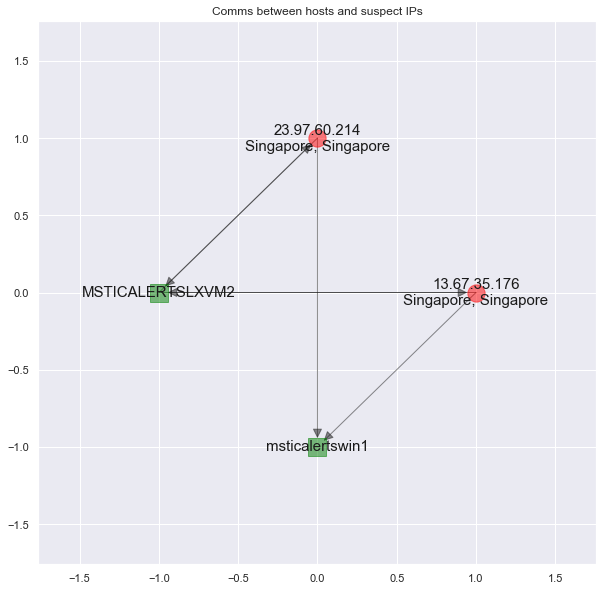

In [34]:
from datetime import timedelta

alert_ips = {'\'{}\''.format(i.Address) for i in alert_ip_entities}
alert_host_ip_list = ','.join(alert_ips)

az_ip_where = f'| where AllExtIPs in ({alert_host_ip_list})'

az_net_query_by_pub_ip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                       start = security_alert.StartTimeUtc - timedelta(3),
                                                       end = security_alert.StartTimeUtc + timedelta(1))
print('getting data...')
%kql -query az_net_query_by_pub_ip
az_net_ext_comms_df = _kql_raw_result_.to_dataframe()
#az_net_ext_comms_df[net_default_cols]

# az_net_ext_comms_df.groupby(['VMName', 'L7Protocol'])['AllowedOutFlows','AllowedInFlows','DeniedInFlows','DeniedOutFlows'].sum()



inv_host_ips = [ent.Address for ent in inv_host_entity.private_ips]
inv_host_ips += [ent.Address for ent in inv_host_entity.public_ips]

alert_ips = [ip.Address for ip in alert_ip_entities]

known_ips = inv_host_ips + alert_ips

# Ips can be in one of 4 columns!
def find_new_ips(known_ips, row):
    new_ips = set()
    if row.VMIPAddress and row.VMIPAddress not in known_ips:
        new_ips.add(row.VMIPAddress)
    if row.SrcIP and row.SrcIP not in known_ips:
        new_ips.add(row.SrcIP)
    if row.DestIP and row.DestIP not in known_ips:
        new_ips.add(row.DestIP)
    if row.PublicIPs:
        for pub_ip in row.PublicIPs:
            if pub_ip not in known_ips:
                new_ips.add(pub_ip)
    if new_ips:            
        return list(new_ips)

new_ips_all = az_net_ext_comms_df.apply(lambda x: find_new_ips(known_ips, x), axis=1).dropna()
new_ips = set()
for ip in [ip for item in new_ips_all for ip in item]:
    new_ips.add(ip)
display(Markdown(f'#### {len(new_ips)} unseen IP Address found in this data: {list(new_ips)}'))



vm_ip = new_ips.pop()
aznet_query = '''
AzureNetworkAnalytics_CL 
| where PrivateIPAddresses_s has \'{vm_ip}\'
| where ResourceType == 'NetworkInterface'
| top 1 by TimeGenerated desc
| project PrivateIPAddresses = PrivateIPAddresses_s, 
    PublicIPAddresses = PublicIPAddresses_s,
    VirtualMachine = VirtualMachine_s
| extend Host = split(VirtualMachine, '/')[-1]
'''.format(vm_ip=vm_ip)
%kql -query aznet_query
az_net_df = _kql_raw_result_.to_dataframe()
if len(az_net_df) > 0:
    host_name = az_net_df['Host'].at[0]

oms_heartbeat_query = '''
Heartbeat
| where ComputerIP == \'{vm_ip}\'
| top 1 by TimeGenerated desc nulls last
| project Computer, ComputerIP, OSType, OSMajorVersion, OSMinorVersion, ResourceId, RemoteIPCountry, 
RemoteIPLatitude, RemoteIPLongitude, SourceComputerId
'''.format(vm_ip=vm_ip)
%kql -query oms_heartbeat_query
oms_heartbeat_df = _kql_raw_result_.to_dataframe()
if len(oms_heartbeat_df) > 0:
    host_name = oms_heartbeat_df['Computer'].at[0]
    

# Get the host entity and add this IP and system info to the 
try:
    if not victim_host_entity:
        victim_host_entity = mas.Host()
        victim_host_entity.HostName = host_name
except NameError:
    victim_host_entity = mas.Host()
    victim_host_entity.HostName = host_name

def convert_to_ip_entities(ip_str):
    ip_entities = []
    if ip_str:
        if ',' in ip_str:
            addrs = ip_str.split(',')
        elif ' ' in ip_str:
            addrs = ip_str.split(' ')
        else:
            addrs = [ip_str]
        for addr in addrs:
            ip_entity = mas.IpAddress()
            ip_entity.Address = addr.strip()
            iplocation.lookup_ip(ip_entity=ip_entity)
            ip_entities.append(ip_entity)
    return ip_entities

# Add this information to our inv_host_entity
retrieved_pub_addresses = []
if len(az_net_df) == 1:
    priv_addr_str = az_net_df['PrivateIPAddresses'].loc[0]
    victim_host_entity.properties['private_ips'] = convert_to_ip_entities(priv_addr_str)

    pub_addr_str = az_net_df['PublicIPAddresses'].loc[0]
    victim_host_entity.properties['public_ips'] = convert_to_ip_entities(pub_addr_str)
    retrieved_pub_addresses = [ip.Address for ip in victim_host_entity.properties['public_ips']]
    
if len(oms_heartbeat_df) == 1:
    if oms_heartbeat_df['ComputerIP'].loc[0]:
        oms_address = oms_heartbeat_df['ComputerIP'].loc[0]
        if oms_address not in retrieved_address:
            ip_entity = mas.IpAddress()
            ip_entity.Address = oms_address
            iplocation.lookup_ip(ip_entity=ip_entity)
            inv_host_entity.properties['public_ips'].append(ip_entity)
        
    victim_host_entity.OSFamily = oms_heartbeat_df['OSType'].loc[0]
    victim_host_entity.AdditionalData['OSMajorVersion'] = oms_heartbeat_df['OSMajorVersion'].loc[0]
    victim_host_entity.AdditionalData['OSMinorVersion'] = oms_heartbeat_df['OSMinorVersion'].loc[0]
    victim_host_entity.AdditionalData['SourceComputerId'] = oms_heartbeat_df['SourceComputerId'].loc[0]

print(f'Found New Host Entity {victim_host_entity.HostName}\n')
print(victim_host_entity)

add_observation(Observation(caption=f'Second victim host identified {victim_host_entity.HostName}',
                            description='Description of host entity shown in attachment.',
                            item=victim_host_entity,
                            link='other_hosts_to_ips'))



sns.set()
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

ip_graph = nx.DiGraph(id='IPGraph')

def add_vm_node(graph, host_entity):
    vm_name = host_entity.HostName
    vm_ip = host_entity.private_ips[0].Address
    vm_desc = f'{host_entity.HostName}'
    ip_graph.add_node(vm_ip, name=vm_name, description=vm_desc,
                      node_type='host')

for ip_entity in alert_ip_entities:
    if 'Location' in ip_entity:
        ip_desc = f'{ip_entity.Address}\n{ip_entity.Location.City}, {ip_entity.Location.CountryName}'
    else:
        ip_desc = 'unknown location'
    ip_graph.add_node(ip_entity.Address, name=ip_entity.Address, description=ip_desc, node_type='ip')

add_vm_node(ip_graph, inv_host_entity)
add_vm_node(ip_graph, victim_host_entity)


def add_edges(graph, row): 
    dest_ip = row.DestIP if row.DestIP else row.VMIPAddress
    if row.SrcIP:
        src_ip = row.SrcIP
        ip_graph.add_edge(src_ip, dest_ip)
    else:
        for ip in row.PublicIPs:
            src_ip = ip
            ip_graph.add_edge(src_ip, dest_ip)

    
# Add edges from network data
az_net_ext_comms_df.apply(lambda x: add_edges(ip_graph, x),axis=1)

src_node = [n for (n, node_type) in
            nx.get_node_attributes(ip_graph, 'node_type').items()
            if node_type == 'ip']
vm_nodes = [n for (n, node_type) in
            nx.get_node_attributes(ip_graph, 'node_type').items()
            if node_type == 'host']

# now draw them in subsets  using the `nodelist` arg
plt.rcParams['figure.figsize'] = (10, 10)
plt.margins(x=0.3, y=0.3)
plt.title('Comms between hosts and suspect IPs')
pos = nx.circular_layout(ip_graph)
nx.draw_networkx_nodes(ip_graph, pos, nodelist=src_node,
                       node_color='red', alpha=0.5, node_shape='o')
nx.draw_networkx_nodes(ip_graph, pos, nodelist=vm_nodes,
                       node_color='green', alpha=0.5, node_shape='s',
                       s=400)
nlabels = nx.get_node_attributes(ip_graph, 'description')
nx.relabel_nodes(ip_graph, nlabels)
nx.draw_networkx_labels(ip_graph, pos, nlabels, font_size=15)
nx.draw_networkx_edges(ip_graph, pos, alpha=0.5, arrows=True, arrowsize=20);


### Observations
- We have found a new IP address that our attacker has also been communicating with. We should investigate that machine.
- From the name looks like a Windows host
- There is also another public IP involved that has been taking to both hosts. We should look at that.

<a id='other_host_investigate'></a>[Contents](#toc)
# Other Hosts Communicating with IP
Investigating the second host in the attack graph.

<a id='host_logons'></a>[Contents](#toc)
## Check Host Logons

In [35]:


from msticpy.nbtools.query_defns import DataFamily, DataEnvironment
params_dict = {}
params_dict.update(security_alert.query_params)
params_dict['host_filter_eq'] = f'Computer has \'{victim_host_entity.HostName}\''
params_dict['host_filter_neq'] = f'Computer !has \'{victim_host_entity.HostName}\''
params_dict['host_name'] = victim_host_entity.HostName
params_dict['start'] = security_alert.origin_time - timedelta(days=5)
params_dict['end'] = security_alert.origin_time + timedelta(days=1)
if victim_host_entity.OSFamily == 'Linux':
    params_dict['data_family'] = DataFamily.LinuxSecurity
    params_dict['path_separator'] = '/'
else:
    params_dict['data_family'] = DataFamily.WindowsSecurity
    params_dict['path_separator'] = '\\'

# # set the origin time to the time of our alert
# logon_query_times = mas.QueryTime(units='day', origin_time=security_alert.origin_time,
#                                   before=5, after=1, max_before=20, max_after=20)
# logon_query_times.display()



from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score
print('getting data...')
host_logons = qry.list_host_logons(**params_dict)


if len(host_logons) > 0:
    logon_features = host_logons.copy()
    logon_features['AccountNum'] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
    logon_features['LogonIdNum'] = host_logons.apply(lambda x: _string_score(x.TargetLogonId), axis=1)
    logon_features['LogonHour'] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_logons, _, _) = dbcluster_events(data=logon_features, time_column='TimeGenerated',
                                           cluster_columns=['AccountNum',
                                                            'LogonType'],
                                           max_cluster_distance=0.0001)
#     %matplotlib inline
#     plt.rcParams['figure.figsize'] = (12, 4)
#     clus_logons.plot.barh(x="Account", y="ClusterSize")

#     display(Markdown(f'Number of input events: {len(host_logons)}'))
#     display(Markdown(f'Number of clustered events: {len(clus_logons)}'))
#     display(Markdown('#### Distinct host logon patterns'))
#     clus_logons.sort_values('TimeGenerated')
#     nbdisp.display_logon_data(clus_logons)
# else:
#     display(Markdown('No logon events found for host.'))

display(Markdown('### Classification of Logon Types by Account'))

display(Markdown('### Counts of logon events by logon type.'))
display(Markdown('Min counts for each logon type highlighted.'))
logon_by_type = (host_logons[['Account', 'LogonType', 'EventID']]
                .groupby(['Account','LogonType']).count().unstack()
                .fillna(0)
                .style
                .background_gradient(cmap='viridis', low=.5, high=0)
                .format("{0:0>3.0f}"))
display(logon_by_type)
key = 'logon type key = {}'.format(';  '.join([f'{k}:{v}' for k,v in mas.nbdisplay._WIN_LOGON_TYPE_MAP.items()]))
display(Markdown(key))

display(Markdown('### Logon Timeline'))
nbdisp.display_timeline(data=host_logons,
                         overlay_data=host_logons.query('LogonType == 10'),
                         alert=security_alert, 
                         source_columns=['Account', 'LogonType', 'TimeGenerated'],
                         title='All Host Logons (RDP Logons in green)')

add_observation(Observation(caption='RDP Logons seen for victim #2',
                            description='Logons by logon type.',
                            item=logon_by_type,
                            link='victim2_logon_types'))

display(Markdown('### Failed Logons'))

failedLogons = qry.list_host_logon_failures(**params_dict)
if failedLogons.shape[0] == 0:
    display(print('No logon failures recorded for this host between {security_alert.start} and {security_alert.start}'))
else:
    display(failedLogons)
    add_observation(Observation(caption='Logon failures seen for victim #2',
                            description=f'{len(failedLogons)} Logons seen.',
                            item=failedLogons,
                            link='failed_logons'))

getting data...


### Classification of Logon Types by Account

### Counts of logon events by logon type.

Min counts for each logon type highlighted.

logon type key = 0:Unknown;  2:Interactive;  3:Network;  4:Batch;  5:Service;  7:Unlock;  8:NetworkCleartext;  9:NewCredentials;  10:RemoteInteractive;  11:CachedInteractive

### Logon Timeline

Loading BokehJS ...

Alert start time =  2019-02-16 03:23:54


### Failed Logons

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-16 00:06:02.193,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,ian,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1120,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,2,Negotiate,0xc000006d,-,MSTICAlertsWin1
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-15 04:09:38.523,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-14 04:23:55.400,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-13 16:28:05.417,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,ian,MSTICAlertsWin1,S-1-0-0,,Advapi,4,Negotiate,0xc000015b,-,MSTICAlertsWin1
4,52b1ab41-869e-4138-9e40-2a4457f09bf0,MSTICAlertsWin1\ian,4625,2019-02-12 20:28:38.637,263a788b-6526-4cdc-8ed9-d79402fe4aa0,MSTICAlertsWin1,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,ian,MSTICAlertsWin1,S-1-0-0,,seclogo,2,Negotiate,0xc000006d,::1,MSTICAlertsWin1


### Observations
- We see some Network and RemoteInteractive logons - some occuring around the time leading up to the original alert.
- From the failed logons it looks like a few attempts were made to logon to the account name "ian".
- Once the logon succeeded our attacker logged in using remote desktop.

<a id='examine_win_logon_sess'></a>[Contents](#toc)
## Examine a Logon Session

### Select a Logon ID To Examine

In [36]:


import re
dist_logons = clus_logons.sort_values('TimeGenerated')[['TargetUserName', 'TimeGenerated', 
                                                        'LastEventTime', 'LogonType', 
                                                        'ClusterSize']]
items = dist_logons.apply(lambda x: (f'{x.TargetUserName}:    '
                                     f'(logontype={x.LogonType})   '
                                     f'timerange={x.TimeGenerated} - {x.LastEventTime}    '
                                     f'count={x.ClusterSize}'),
                          axis=1).values.tolist()
def get_selected_logon_cluster(selected_item):
    acct_match = re.search(r'(?P<acct>[^:]+):\s+\(logontype=(?P<l_type>[^)]+)', selected_item)
    if acct_match:
        acct = acct_match['acct']
        l_type = int(acct_match['l_type'])
        return host_logons.query('TargetUserName == @acct and LogonType == @l_type')

def get_selected_logon(selected_item):
    logon_list_regex = r'''
(?P<acct>[^:]+):\s+
\(logontype=(?P<logon_type>[^)]+)\)\s+
\(timestamp=(?P<time>[^)]+)\)\s+
logonid=(?P<logonid>[0-9a-fx)]+)
'''
    acct_match = re.search(logon_list_regex, selected_item, re.VERBOSE)
    if acct_match:
        acct = acct_match['acct']
        logon_type = int(acct_match['logon_type'])
        time_stamp = pd.to_datetime(acct_match['time'])
        logon_id = acct_match['logonid']
        return host_logons.query('TargetUserName == @acct and LogonType == @logon_type'
                                 ' and TargetLogonId == @logon_id')
    
logon_wgt = mas.SelectString(description='Select logon cluster to examine', 
                             item_list=items, height='200px', width='100%', auto_display=True)

Select(description='Select logon cluster to examine', layout=Layout(height='200px', width='100%'), options=('M…

### Observations
- Select the logon account and type that we're interested in

<a id='process_clustering'></a>[Contents](#toc)
## Unusual Processes on Host - Clustering
Sometimes you don't have a source process to work with. Other times it's just useful to see what else is going on on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

You can display the raw output of this by looking at the *processes_on_host* dataframe. Just copy this into a new cell and hit Ctrl-Enter.

Usually though, the results return a lot of very repetitive and unintersting system processes so we attempt to cluster these to make the view easier to negotiate. 
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

In [37]:
selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)

# Calculate time range based on the logons from previous section
logon_time = selected_logon_cluster['TimeGenerated'].min()
last_logon_time = selected_logon_cluster['TimeGenerated'].max()
time_diff_delta = (last_logon_time - logon_time)

# set the origin time to the time of our alert
params_dict['start'] = logon_time - timedelta(seconds=(1 * 60 * 60))
params_dict['end'] = logon_time + time_diff_delta + timedelta(seconds=(2 * 60 * 60))


from msticpy.sectools.eventcluster import dbcluster_events, add_process_features
print('Getting process events...', end='')
processes_on_host = qry.list_processes(**params_dict)
print('done')
print('Clustering...', end='')
feature_procs = add_process_features(input_frame=processes_on_host,
                                     path_separator=params_dict['path_separator'])

feature_procs['accountNum'] = feature_procs.apply(lambda x: _string_score(x.Account), axis=1)
# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore',
                                                                     'accountNum',
                                                                     'isSystemSession'],
                                                    max_cluster_distance=0.0001)
print('done')
print('Number of input events:', len(feature_procs))
print('Number of clustered events:', len(clus_events))
(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                          'NewProcessName', 'CommandLine', 
                                          'ClusterSize', 'commandlineTokensFull',
                                          'pathScore', 'isSystemSession']]
    .sort_values('ClusterSize', ascending=False))
print('done')


display(Markdown('### View processes used in login session'))

selected_logon_cluster = get_selected_logon_cluster(logon_wgt.value)

def view_logon_sess(x=''):
    global selected_logon
    selected_logon = get_selected_logon(x)
    display(selected_logon)
    logonId = selected_logon['TargetLogonId'].iloc[0]
    sess_procs = (processes_on_host.query('TargetLogonId == @logonId | SubjectLogonId == @logonId')
                                          [['NewProcessName', 'CommandLine', 'TargetLogonId']]
                  .drop_duplicates())
    display(sess_procs)
    

items = selected_logon_cluster.sort_values('TimeGenerated').apply(lambda x: (f'{x.TargetUserName}:    '
                                        f'(logontype={x.LogonType})   '
                                        f'(timestamp={x.TimeGenerated})    '
                                        f'logonid={x.TargetLogonId}'),
                             axis=1).values.tolist()
sess_w = widgets.Select(options=items, description='Select logon instance to examine', **WIDGET_DEFAULTS)
    
interactive(view_logon_sess, x=sess_w)

Getting process events...done
Clustering...done
Number of input events: 2046
Number of clustered events: 151
done


### View processes used in login session

interactive(children=(Select(description='Select logon instance to examine', layout=Layout(width='95%'), optio…

### Observations
- First session listed doesn't look interesting 
- but the second shows:
  - Accounts being added
  - Accounts added to local Administrators group
  - Permissions removed on RPD/Terminal services logon
  - Scheduled task being installed as a means of persistence

In [38]:
display(Markdown('### EventTypes login session in select time interval'))

all_events_base_qry = '''
SecurityEvent
| where Computer =~ '{host}'
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where {where_filter}
'''
all_events_qry = all_events_base_qry.format(host=params_dict['host_name'],
                                            start=params_dict['start'],
                                            end=params_dict['end'],
                                            where_filter='EventID != 4688 and EventID != 4624')

%kql -query all_events_qry
all_events_df = _kql_raw_result_.to_dataframe()
display(all_events_df[['Account', 'Activity', 'TimeGenerated']]
        .groupby(['Account', 'Activity']).count())

add_observation(Observation(caption='System account modifications during attack.',
                            description='Count of event types seen on system',
                            item=all_events_df[['Account', 'Activity', 'TimeGenerated']].groupby(['Account', 'Activity']).count(),
                            link='other_win_events'))

### EventTypes login session in select time interval

TimeGenerated
Account                    Activity                                                                                            
                           4776 - The domain controller attempted to validate the credentials for an account.                 7
                           5058 - Key file operation.                                                                        14
                           5061 - Cryptographic operation.                                                                   14
MSTICAlertsWin1\MSTICAdmin 4634 - An account was logged off.                                                                  1
                           4798 - A user's local group membership was enumerated.                                             1
                           8002 - A process was allowed to run.                                                              51
MSTICAlertsWin1\ian        4625 - An account failed to log on.                                                                1
                           4634 - An account was logged off.                                                                  7
                           4672 - Special privileges assigned to new logon.                                                  11
                           4720 - A user account was created.                                                                 1
                           4722 - A user account was enabled.                                                                 1
                           4724 - An attempt was made to reset an account's password.                                         2
                           4726 - A user account was deleted.                                                                 1
                           4728 - A member was added to a security-enabled global group.                                      1
                           4729 - A member was removed from a security-enabled global group.                                  1
                           4732 - A member was added to a security-enabled local group.                                       2
                           4733 - A member was removed from a security-enabled local group.                                   2
                           4738 - A user account was changed.                                                                 3
                           4797 - An attempt was made to query the existence of a blank password for an account.              4
                           4798 - A user's local group membership was enumerated.                                            26
                           4799 - A security-enabled local group membership was enumerated                                    3
                           8002 - A process was allowed to run.                                                             226
NT AUTHORITY\SYSTEM        4672 - Special privileges assigned to new logon.                                                  18
                           8002 - A process was allowed to run.                                                               6
WORKGROUP\MSTICAlertsWin1$ 4648 - A logon was attempted using explicit credentials.                                           5
                           4798 - A user's local group membership was enumerated.                                            84
                           4799 - A security-enabled local group membership was enumerated                                   33
                           5059 - Key migration operation.                                                                   24
Window Manager\DWM-3       4672 - Special privileges assigned to new logon.                                                   2
Window Manager\DWM-4       4634 - An account was logged off.                                                                  2
                  

### Observations
Some unusual events associated with our compromised account session:
- Logon failure
- Account creation
- Password reset
- Security group changes

<a id='o365'></a>[Contents](#toc)
# Office 365 Activity
### Check our Office Subscription for anything suspicious

In [39]:
o365_start = security_alert.origin_time - timedelta(seconds=(60 * 60))
o365_end = security_alert.origin_time + timedelta(seconds=(10 * 60 * 60))

print('Running queries...', end=' ')
# Queries
ad_changes_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType == 'AzureActiveDirectory'
| where Operation in ('Add service principal.',
                      'Change user password.', 
                      'Add user.', 
                      'Add member to role.')
| where UserType == 'Regular' 
| project OfficeId, TimeGenerated, Operation, OrganizationId, 
          OfficeWorkload, ResultStatus, OfficeObjectId, 
          UserId = tolower(UserId), ClientIP, ExtendedProperties
'''.format(start = o365_start, end=o365_end)
%kql -query ad_changes_query
ad_changes_df = _kql_raw_result_.to_dataframe()


office_ops_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| union (
    OfficeActivity 
    | where TimeGenerated >= datetime({start})
    | where TimeGenerated <= datetime({end})
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
'''.format(start = o365_start, end=o365_end)
%kql -query office_ops_query
office_ops_df = _kql_raw_result_.to_dataframe()

office_ops_summary_query = '''
let timeRange=ago(30d);
let officeAuthentications = OfficeActivity
| where TimeGenerated >= timeRange
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
officeAuthentications
| union (
    OfficeActivity 
    | where TimeGenerated >= timeRange
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
| extend RecordOp = strcat(RecordType, '-', Operation)
| summarize OpCount=count() by RecordType, Operation, UserId, UserAgent, ClientIP, bin(TimeGenerated, 1h)
// render timeline
'''.format(start = o365_start, end=o365_end)
%kql -query office_ops_summary_query
office_ops_summary_df = _kql_raw_result_.to_dataframe()
# %kql -query office_ops_query
# office_ops_df = _kql_raw_result_.to_dataframe()

# office_logons_query = '''
# let timeRange=ago(30d);
# let officeAuthentications = OfficeActivity
# | where TimeGenerated >= timeRange
# | where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
# | extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
# | where Operation == "UserLoggedIn";
# let lookupWindow = 1d;
# let lookupBin = lookupWindow / 2.0; 
# officeAuthentications | project-rename Start=TimeGenerated
# | extend TimeKey = bin(Start, lookupBin)
# | join kind = inner (
#     officeAuthentications
#     | project-rename End=TimeGenerated
#     | extend TimeKey = range(bin(End - lookupWindow, lookupBin), bin(End, lookupBin), lookupBin)
#     | mvexpand TimeKey to typeof(datetime)
# ) on UserAgent, TimeKey
# | project timeSpan = End - Start, UserId, ClientIP , UserAgent , Start, End
# | summarize dcount(ClientIP) by  UserAgent
# | where dcount_ClientIP > 1
# | join kind=inner (  
# officeAuthentications
# | summarize minTime=min(TimeGenerated), maxTime=max(TimeGenerated) by UserId, UserAgent, ClientIP
# ) on UserAgent
# '''
# %kql -query office_logons_query
# office_logons_df = _kql_raw_result_.to_dataframe()

print('done.')

# Any IP Addresses in our alert IPs that match?
display(Markdown('### Any IP Addresses in our alert IPs that match Office Activity?'))

for ip in alert_ip_entities:
    susp_o365_activities = office_ops_df[office_ops_df['ClientIP'] == ip.Address]
    susp_o365_summ = (office_ops_df[office_ops_df['ClientIP'] == ip.Address]
                         [['OfficeId', 'UserId', 'RecordType', 'Operation']]
                         .groupby(['UserId', 'RecordType', 'Operation']).count()
                         .rename(columns={'OfficeId': 'OperationCount'}))
    
    display(Markdown(f'### Activity for {ip.Address}'))
    if len(susp_o365_summ) > 0:
        display(susp_o365_summ)
        add_observation(Observation(caption=f'O365 activity from suspected attacker IP {ip.Address}',
                                    description=f'Summarized operation count for each user/service/operation type',
                                    item=susp_o365_summ,
                                    link='o365_match_ip'))
    else:
        display(Markdown('No activity detected'))


for susp_ip in [ip.Address for ip in alert_ip_entities]:

    suspect_ip_ops = office_ops_df[office_ops_df['ClientIP'] == susp_ip]
    
    display(Markdown(f'### Timeline of operations originating from suspect IP Address: {susp_ip}'))
    display(Markdown(f'**{susp_ip}**'))
    if len(suspect_ip_ops) == 0:
        display(Markdown('No activity detected'))
        continue
    sel_op_type='FileDownloaded'
    nbdisp.display_timeline(data=suspect_ip_ops, title=f'Operations from {susp_ip} (all=blue, {sel_op_type}=green)',
                            overlay_data=suspect_ip_ops.query('Operation == @sel_op_type'),
                            height=200,
                            source_columns=['UserId', 'RecordType', 'Operation'])
    
    # Uncomment line below to see all activity
    # display(suspect_ip_ops.sort_values('TimeGenerated', ascending=True).head())


display(Markdown('### Evidence of automated or bulk uploads/downloads'))

timed_slice_ops = office_ops_df[['RecordType', 'TimeGenerated', 'Operation',
       'OrganizationId', 'UserType', 'OfficeWorkload',
       'ResultStatus', 'OfficeObjectId', 'UserId', 'ClientIP', 'Start_Time']]
timed_slice_ops2 = timed_slice_ops.set_index('TimeGenerated')

hi_freq_ops = (timed_slice_ops2[['UserId', 'ClientIP', 'Operation', 'RecordType']]
                .groupby(['UserId', 'ClientIP', 'RecordType', 'Operation']).resample('10S').count()
                .query('RecordType > 10')
                .drop(['ClientIP', 'UserId', 'RecordType'], axis=1)
                .assign(OpsPerSec = lambda x: x.Operation / 10)
                .rename(columns={'Operation': 'Operation Count'}))

if len(hi_freq_ops) > 0:
    display(hi_freq_ops)
    add_observation(Observation(caption=f'O365 bulk/high freq operations seen',
                                    description=f'Summarized operation count bulk actions',
                                    item=hi_freq_ops,
                                    link='o356_high_freq'))

Running queries... done.


### Any IP Addresses in our alert IPs that match Office Activity?

### Activity for 13.67.35.176

No activity detected

### Activity for 23.97.60.214

OperationCount
UserId                           RecordType                   Operation                      
ianh@M365x054215.onmicrosoft.com AzureActiveDirectoryStsLogon UserLoggedIn                 17
ianh@m365x054215.onmicrosoft.com AzureActiveDirectoryStsLogon UserLoginFailed               3
                                 SharePoint                   PageViewed                    1
                                 SharePointFileOperation      FileAccessed                  4
                                                              FileDownloaded               47
                                                              FilePreviewed                 3

### Timeline of operations originating from suspect IP Address: 13.67.35.176

**13.67.35.176**

No activity detected

### Timeline of operations originating from suspect IP Address: 23.97.60.214

**23.97.60.214**

Loading BokehJS ...

### Evidence of automated or bulk uploads/downloads

Operation Count  \
UserId                           ClientIP     RecordType              Operation      TimeGenerated                          
ianh@m365x054215.onmicrosoft.com 23.97.60.214 SharePointFileOperation FileDownloaded 2019-02-16 03:45:00               17   
                                                                                     2019-02-16 03:45:10               17   

                                                                                                          OpsPerSec  
UserId                           ClientIP     RecordType              Operation      TimeGenerated                   
ianh@m365x054215.onmicrosoft.com 23.97.60.214 SharePointFileOperation FileDownloaded 2019-02-16 03:45:00        1.7  
                                                                                     2019-02-16 03:45:10        1.7

### Observations
- Logon failures and success originating from our attacker IP Address
- File download activity
- We also confirm what looks like data exfiltration with another check that looks for high frequency operations for a given user/IP

<a id='appendices'></a>[Contents](#toc)
# Appendices

## Available DataFrames

In [ ]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```